<h1>Power System Analysis and Optimization (5XWA0)</h1>
<h2>Simple unit commitment in PYOMO</h2>

<b>MSc Irena Dukovska</b> <br />
  Electrical Energy Systems Group <br />
  Department of Electrical Engineering <br />
  Eindhoven University of Technology <br />
  (i.dukovska@tue.nl) <br /><br />
  

<h2>Introduction</h2>

In this tutorial we will be developing a model in Python in order to solve and examine the solution of a simple form of the Unit Commitment problem.

The optimization problem is formulated as follows:

\begin{align}
&\text{Minimize} \ C = \sum_{i}(a_i \cdot u_i +b_i \cdot P_i + c_i \cdot P_i^2) \\
&\text{subject to:} \\
&\sum_{i} P_i = D \ \forall i \\
&P_i^{min} \cdot u_i \leq P_i \leq P_i^{max} \cdot u_i \ \forall i \\
&P_i \geq 0 \ \forall i \\
&u_i \in \left\{0,1 \right\}
\end{align}

The basis for this model is the economic dispatch with generation constraints. Note that a new variable ($u_i$) that can only take the values 0 or 1 was added, affecting both the constraints and the objective function. This is no longer a continuous (quadratic programming) problem. The goal of the optimization problem is not only to find the optimal power output of the units as in the economic dispatch problem, but also the optimal set of units that must be online in order to serve the load at minimum cost.

<b>In this tutorial we will:</b> <br>
1) develop an optimization model using Pyomo to solve the problem above <br>
2) use the model in order to define the optimal unit combination and their power output for each load level <br>
3) visualize the results

<h2>Part I: Loading the data</h2>

First, we need to import several packages that we will be using to load the input data, to build the model, and finally, to process and analyze the results.

In [10]:
import pandas
import numpy
from pyomo.environ import *
import matplotlib.pyplot as plt

UnitData = pandas.read_excel('UC_input.xlsx', sheet_name = 'Units', index_col= 0)

print(UnitData)

         a    b      c  Min  Max
                                
Unit1  500  5.3  0.004  200  450
Unit2  400  5.5  0.006  150  350
Unit3  200  5.8  0.009  100  225


<h2>Part II: Defining the model</h2>

The model can be developed in excactly the same way as in the Economic Dispatch tutorial. The only difference is that we now define a function that returns the model in order to solve the problem many times for different load levels.

In [11]:
def unit_commitment(D): #Input is a given load level D
    
    model = ConcreteModel()

    model.I = Set(ordered = True, initialize = UnitData.index)

    model.Pmax = Param(model.I, within = NonNegativeReals, mutable = True)
    model.Pmin = Param(model.I, within = NonNegativeReals, mutable = True)

    model.a = Param(model.I, within = NonNegativeReals, mutable = True)
    model.b = Param(model.I, within = NonNegativeReals, mutable = True)
    model.c = Param(model.I, within = NonNegativeReals, mutable = True)
    
    #Give values to Pmax, Pmin, a, b, c

    for i in model.I:
        model.Pmax[i] = UnitData.loc[i,'Max']
        model.Pmin[i] = UnitData.loc[i,'Min']
        model.a[i] = UnitData.loc[i, 'a']
        model.b[i] = UnitData.loc[i, 'b']
        model.c[i] = UnitData.loc[i, 'c']
        
    #Define decision variables

    model.P = Var(model.I, within = PositiveReals)
    model.u = Var(model.I, within = Binary)
    
    #Define constraints of the problem

    def cost_rule(model):
        return sum(model.a[i]*model.u[i] + model.b[i]*model.P[i]+model.c[i]*model.P[i]*model.P[i] for i in model.I)

    def min_rule(model, i):
        return model.Pmin[i]*model.u[i] <= model.P[i]

    def max_rule(model, i):
        return model.P[i] <= model.Pmax[i]*model.u[i]

    def pbalance_rule(model):
        return sum(model.P[i] for i in model.I) == D

    #Add them to the model

    model.cost = Objective(rule = cost_rule)
    model.min_out_constraints = Constraint(model.I, rule = min_rule)
    model.max_out_constraints = Constraint(model.I, rule = max_rule)
    model.balance = Constraint(rule = pbalance_rule)
    
    #Return the solved model
    opt=SolverFactory('gurobi')
    results=opt.solve(model)
    
    return model

<h2>Part III: Solving the optimization problem for different load levels and saving the results

In [12]:
# Define a numpy array containing all load levels of interest, starting from the minimum possible load supplied by one unit to 
# the maximum load that all units can supply when online
load_step = 10
Load_levels = numpy.arange(UnitData['Min'].min(), UnitData['Max'].sum(), load_step)
# We want to save all the results from the optimization problem in a structured way. One way is with a data frame where  
# the index is the load levels and the results (cost, power output per unit) are in the columns
results_df = pandas.DataFrame(index=Load_levels, columns=['Cost', 'Unit1', 'Unit2', 'Unit3'], dtype=float)

for D in Load_levels:
    model = unit_commitment(D) #Solve optimization problem for demand level D
    
    results_df.loc[D, 'Cost'] = model.cost() # Save the cost value
    for i in model.I:
        results_df.loc[D, i] = model.P[i].value # Save the power outputs per unit
    

print(results_df)

         Cost  Unit1  Unit2  Unit3
100    870.00    0.0    0.0  100.0
110    946.90    0.0    0.0  110.0
120   1025.60    0.0    0.0  120.0
130   1106.10    0.0    0.0  130.0
140   1188.40    0.0    0.0  140.0
...       ...    ...    ...    ...
980   8283.34  450.0  328.0  202.0
990   8378.06  450.0  334.0  206.0
1000  8473.50  450.0  340.0  210.0
1010  8569.66  450.0  346.0  214.0
1020  8666.60  450.0  350.0  220.0

[93 rows x 4 columns]


<h2>Part IV: Visualizing the results </h2>

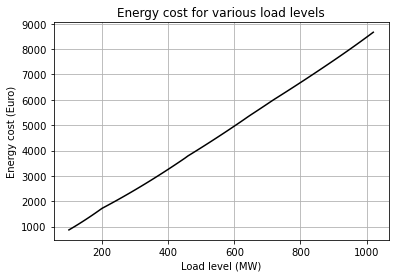

In [13]:
figure = plt.plot(figsize=(12, 8))
plt.plot(results_df.index.to_list(), results_df['Cost'],'black')
plt.title('Energy cost for various load levels')
plt.xlabel('Load level (MW)')
plt.ylabel('Energy cost (Euro)')
plt.grid()
plt.show()

Did you notice a change of slope around 200 MW? Why did this happen?

In [14]:
#  We now want to see which units are online for each load level. 

# We can create a numpy array from the data frame which we later transpose
status_table = results_df[['Unit1', 'Unit2', 'Unit3']].to_numpy()
status_table = numpy.transpose(status_table)

print('Before transformation')
print(status_table[0])
 
status_table[status_table>0] = 1
print('After transformation')
print(status_table[0])

unit_dim = status_table.shape[0] # Number of units 
level_dim = status_table.shape[1] # Number of load levels

Before transformation
[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.         210.         220.         230.         240.
 250.         260.         270.         280.         290.
 300.         310.         320.         330.         340.
 350.         360.         370.         380.         390.
 400.         410.         420.         430.         440.
 450.         337.69230769 344.61538462 351.53846154 358.46153846
 365.38461538 372.30769231 379.23076923 386.15384615 393.07692308
 400.         406.92307692 413.84615385 420.76923077 427.69230769
 434.61538462 441.53846154 448.46153846 450.         450.
 400.         406.         412.         418.         424.
 430.         436.         362.10526316 366.84210526 371.57894737
 376.31578947 381.05263158 385.78947368 390.52631579 395.26315789
 400.         404.73684211 409.47368421 414.21052632 418.94736842
 423.68421053 428.42105263 433.15789473 437.89473679 442.631

Visualize the on-off status of the units for different load levels with Matplotlib

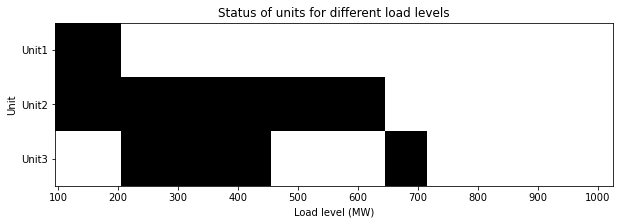

In [15]:
plt.figure(figsize=(10,3))
plt.imshow(status_table, aspect='auto',cmap='gray')
plt.title('Status of units for different load levels')
plt.ylabel('Unit')
plt.xlabel('Load level (MW)')
plt.xticks(numpy.arange(0,level_dim,step=10),numpy.arange(Load_levels[0],Load_levels[-1],step=100))
plt.yticks(numpy.arange(0,unit_dim,step=1),UnitData.index.values)

plt.show()
